In [87]:
from config import plotly_id, plotly_key

import pandas as pd
import numpy as np
import sqlite3

In [88]:
#creating SQL connection
conn = sqlite3.connect('../Data/pet_care_industry.db')
c = conn.cursor()

#function to close connection
def close_c_conn():
    c.close()
    conn.close()

# Exploratory Data Analysis (EDA): Competitor Concentration

In [89]:
#joining business and neighborhood tables from SQL database
businesses_neighborhoods = pd.read_sql_query('''SELECT
    Name,
    Rating,
    Review_Count,
    stores_and_services.ZipCode,
    Neighborhood,
    Borough
    FROM stores_and_services
    LEFT JOIN neighborhoods
    ON stores_and_services.ZipCode = neighborhoods.ZipCode''', conn)

businesses_neighborhoods = businesses_neighborhoods.set_index('Name')
businesses_neighborhoods

,Rating,Review_Count,ZipCode,Neighborhood,Borough
Name,,,,,
NYC Pet,2.5,15,11211,Greenpoint,Brooklyn
NYC Pet,5.0,8,11211,Greenpoint,Brooklyn
Petland Discounts,3.5,6,11237,Bushwick and Williamsburg,Brooklyn
Park slope Pet,5.0,10,11215,Northwest Brooklyn,Brooklyn
Petland Discounts,3.0,19,11216,Central Brooklyn,Brooklyn
Pet Central,3.5,6,10128,Upper East Side,Manhattan
Petland Discounts,2.5,9,11206,Bushwick and Williamsburg,Brooklyn
Pet Valu,3.0,14,7002,None,None
"Slope Pet Food Supplies, Inc",5.0,8,11215,Northwest Brooklyn,Brooklyn


In [90]:
businesses_neighborhoods.describe()

,Rating,Review_Count,ZipCode
count,1502.000000,1502.000000,1502.000000
mean,4.036618,30.506658,10028.626498
std,0.945724,39.018705,2366.409873
min,1.000000,1.000000,6830.000000
25%,3.500000,7.000000,10003.000000
50%,4.500000,17.000000,10128.000000
75%,5.000000,39.000000,11217.000000
max,5.000000,384.000000,80301.000000


In [91]:
concentration = businesses_neighborhoods.groupby('Name').size().reset_index(name='Stores')
concentration = concentration.sort_values(by='Stores', ascending=False)
concentration['Share %'] = concentration['Stores'] / concentration['Stores'].sum() * 100
concentration['Concentration Index'] = concentration['Share %'].cumsum()
concentration = concentration.reset_index()
concentration = concentration.drop('index', axis=1)
concentration.index = concentration.index + 1
concentration.head(8)

,Name,Stores,Share %,Concentration Index
1,Petco,46,3.062583,3.062583
2,Petland Discounts,43,2.862850,5.925433
3,PetSmart,26,1.731025,7.656458
4,Banfield Pet Hospital,18,1.198402,8.854860
5,Pet Valu,14,0.932091,9.786951
6,Pet Supplies Plus,13,0.865513,10.652463
7,Pet Central,9,0.599201,11.251664
8,Biscuits & Bath,9,0.599201,11.850866


In [92]:
HHI_industry = sum(concentration['Share %']**2)
HHI_industry

30.921930989485492

In [93]:
n_concentration = businesses_neighborhoods.groupby('Neighborhood').size().reset_index(name='Stores')
n_concentration = n_concentration.sort_values(by='Stores', ascending=False)
n_concentration['Share %'] = n_concentration['Stores'] / n_concentration['Stores'].sum() * 100
n_concentration['Concentration Index'] = n_concentration['Share %'].cumsum()
n_concentration = n_concentration.reset_index()
n_concentration = n_concentration.drop('index', axis=1)
n_concentration.index = n_concentration.index + 1
n_concentration.head(8)

,Neighborhood,Stores,Share %,Concentration Index
1,Northwest Brooklyn,94,9.055877,9.055877
2,Chelsea and Clinton,79,7.610790,16.666667
3,Northwest Queens,73,7.032755,23.699422
4,Upper East Side,72,6.936416,30.635838
5,Upper West Side,65,6.262042,36.897881
6,Lower East Side,47,4.527938,41.425819
7,Greenpoint,44,4.238921,45.664740
8,Greenwich Village and Soho,44,4.238921,49.903661


In [94]:
HHI_neighborhood = sum(n_concentration['Share %']**2)
HHI_neighborhood

447.5035361466582

# Exploratory Data Analysis (EDA): Market Size

In [100]:
#initialize dog growth table with unique list of neighborhoods
key = 'Neighborhood'
dog_growth = pd.read_sql_query('SELECT DISTINCT {}, Borough FROM neighborhoods'.format(key), conn)
dog_growth = dog_growth.set_index(key)
print(dog_growth.shape)
dog_growth.head()

(42, 1)


,Borough
Neighborhood,
Chelsea and Clinton,Manhattan
Lower East Side,Manhattan
Lower Manhattan,Manhattan
Gramercy Park and Murray Hill,Manhattan
Greenwich Village and Soho,Manhattan


In [101]:
#function to select dogs by neighborhoods for a given year
def get_dogs_by_year(year):
    return pd.read_sql_query("""SELECT {}, LicenseIssuedYear AS CY{}
                                FROM dogs
                                LEFT JOIN neighborhoods
                                ON dogs.ZipCode = neighborhoods.ZipCode
                                WHERE LicenseIssuedYear <= {}
                                AND LicenseExpiredYear >= {};""".format(key, year, year, year), conn)

for i in range(2014, 2023):
    dog_growth = pd.merge(dog_growth, get_dogs_by_year(i).groupby(key).count(), on=key, how='left')
    
dog_growth['CY2022'] = dog_growth['CY2022'].fillna(0).astype(int)
dog_growth

,Borough,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022
Neighborhood,,,,,,,,,,
Chelsea and Clinton,Manhattan,113,2312,5995,4163,904,448,310,157,2
Lower East Side,Manhattan,89,1817,4770,3273,657,327,184,92,1
Lower Manhattan,Manhattan,35,711,1779,1217,261,121,80,38,0
Gramercy Park and Murray Hill,Manhattan,73,1486,3912,2723,583,280,192,95,2
Greenwich Village and Soho,Manhattan,59,1155,3077,2180,485,244,173,87,1
Upper East Side,Manhattan,126,2689,7265,5089,976,444,298,140,3
Upper West Side,Manhattan,177,2807,7679,5484,1121,505,316,140,5
Central Harlem,Manhattan,37,885,2268,1532,276,123,80,46,3
East Harlem,Manhattan,25,779,2096,1422,248,127,88,48,3


In [102]:
total_market = dog_growth.sum()
total_market

Borough    ManhattanManhattanManhattanManhattanManhattanM...
CY2014                                                  1879
CY2015                                                 44522
CY2016                                                120031
CY2017                                                 82505
CY2018                                                 13451
CY2019                                                  6007
CY2020                                                  3884
CY2021                                                  1940
CY2022                                                    52
dtype: object

In [103]:
dog_growth['5Y CAGR 2014-2019'] = (((dog_growth['CY2019'] / dog_growth['CY2014']) ** (1/5)) - 1) * 100
dog_growth = dog_growth.sort_values(by=['5Y CAGR 2014-2019'], ascending=False)
dog_growth = dog_growth.replace(np.inf, np.nan)
dog_growth = dog_growth.dropna(subset=['5Y CAGR 2014-2019'])
dog_growth

,Borough,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022,5Y CAGR 2014-2019
Neighborhood,,,,,,,,,,,
Southwest Queens,Queens,26,1078,2929,1969,294,135,91,49,1,39.018335
East Harlem,Manhattan,25,779,2096,1422,248,127,88,48,3,38.411681
Flatbush,Brooklyn,13,741,1906,1236,168,55,31,16,1,33.439335
High Bridge and Morrisania,Bronx,11,512,1302,824,92,46,30,13,0,33.129110
Greenwich Village and Soho,Manhattan,59,1155,3077,2180,485,244,173,87,1,32.833484
Chelsea and Clinton,Manhattan,113,2312,5995,4163,904,448,310,157,2,31.716419
West Queens,Queens,53,1694,4452,2999,465,209,135,65,1,31.575213
Gramercy Park and Murray Hill,Manhattan,73,1486,3912,2723,583,280,192,95,2,30.847984
Borough Park,Brooklyn,30,915,2540,1770,282,112,82,45,0,30.142562


In [104]:
dog_growth['Share 2016'] = dog_growth['CY2019'] / total_market['CY2019'] * 100
dog_growth = dog_growth.sort_values(by=['Share 2016'], ascending=False)
dog_growth

,Borough,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022,5Y CAGR 2014-2019,Share 2016
Neighborhood,,,,,,,,,,,,
Upper West Side,Manhattan,177,2807,7679,5484,1121,505,316,140,5,23.328549,8.406859
Northwest Brooklyn,Brooklyn,139,2591,6728,4736,998,494,334,151,6,28.867211,8.223739
Chelsea and Clinton,Manhattan,113,2312,5995,4163,904,448,310,157,2,31.716419,7.457966
Upper East Side,Manhattan,126,2689,7265,5089,976,444,298,140,3,28.647836,7.391377
Lower East Side,Manhattan,89,1817,4770,3273,657,327,184,92,1,29.727351,5.443649
Gramercy Park and Murray Hill,Manhattan,73,1486,3912,2723,583,280,192,95,2,30.847984,4.661229
Greenwich Village and Soho,Manhattan,59,1155,3077,2180,485,244,173,87,1,32.833484,4.061928
West Queens,Queens,53,1694,4452,2999,465,209,135,65,1,31.575213,3.479274
South Shore,Staten Island,63,1803,5567,4025,454,175,104,52,1,22.670320,2.913268


In [122]:
bcg_matrix = pd.merge(dog_growth, n_concentration, on=key, how='left')
bcg_matrix = bcg_matrix.drop(columns=['Share %', 'Concentration Index'])
bcg_matrix['Dogs per Store'] = bcg_matrix['CY2016'] / bcg_matrix['Stores']
bcg_matrix['Dogs per Store'] = bcg_matrix['Dogs per Store'].astype(int)
bcg_matrix['5Y CAGR 2014-2019'] = bcg_matrix['5Y CAGR 2014-2019'].round(2)
bcg_matrix['Share 2016'] = bcg_matrix['Share 2016'].round(2)
bcg_matrix

,Neighborhood,Borough,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022,5Y CAGR 2014-2019,Share 2016,Stores,Dogs per Store
0,Upper West Side,Manhattan,177,2807,7679,5484,1121,505,316,140,5,23.33,8.41,65,118
1,Northwest Brooklyn,Brooklyn,139,2591,6728,4736,998,494,334,151,6,28.87,8.22,94,71
2,Chelsea and Clinton,Manhattan,113,2312,5995,4163,904,448,310,157,2,31.72,7.46,79,75
3,Upper East Side,Manhattan,126,2689,7265,5089,976,444,298,140,3,28.65,7.39,72,100
4,Lower East Side,Manhattan,89,1817,4770,3273,657,327,184,92,1,29.73,5.44,47,101
5,Gramercy Park and Murray Hill,Manhattan,73,1486,3912,2723,583,280,192,95,2,30.85,4.66,42,93
6,Greenwich Village and Soho,Manhattan,59,1155,3077,2180,485,244,173,87,1,32.83,4.06,44,69
7,West Queens,Queens,53,1694,4452,2999,465,209,135,65,1,31.58,3.48,23,193
8,South Shore,Staten Island,63,1803,5567,4025,454,175,104,52,1,22.67,2.91,16,347
9,Northwest Queens,Queens,59,1264,3402,2337,388,173,117,64,1,24.00,2.88,73,46


In [130]:
bcg_matrix.describe()

,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022,5Y CAGR 2014-2019,Share 2016,Stores,Dogs per Store
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.00000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,44.738095,1060.047619,2857.880952,1964.404762,320.261905,143.02381,92.476190,46.190476,1.238095,24.795000,2.380952,24.714286,265.166667
std,37.001687,639.674687,1739.987780,1244.729005,264.212503,128.59892,85.566188,40.302659,1.393531,6.665151,2.140296,23.458615,318.395207
min,8.000000,403.000000,1131.000000,692.000000,61.000000,22.00000,14.000000,6.000000,0.000000,10.520000,0.370000,1.000000,44.000000
25%,19.500000,527.500000,1491.250000,1010.000000,135.750000,51.00000,31.750000,16.250000,0.000000,19.170000,0.847500,8.500000,99.250000
50%,33.500000,857.500000,2310.000000,1579.500000,259.500000,120.50000,76.000000,36.000000,1.000000,24.570000,2.005000,18.000000,119.000000
75%,59.000000,1250.750000,3370.750000,2309.250000,387.000000,162.75000,103.750000,54.250000,2.000000,29.577500,2.710000,33.500000,313.250000
max,177.000000,2807.000000,7679.000000,5484.000000,1121.000000,505.00000,334.000000,157.000000,6.000000,39.020000,8.410000,94.000000,1302.000000


Text(9.549999999999997, 0.5, '5-Year CAGR from 2014 to 2019 [%]')

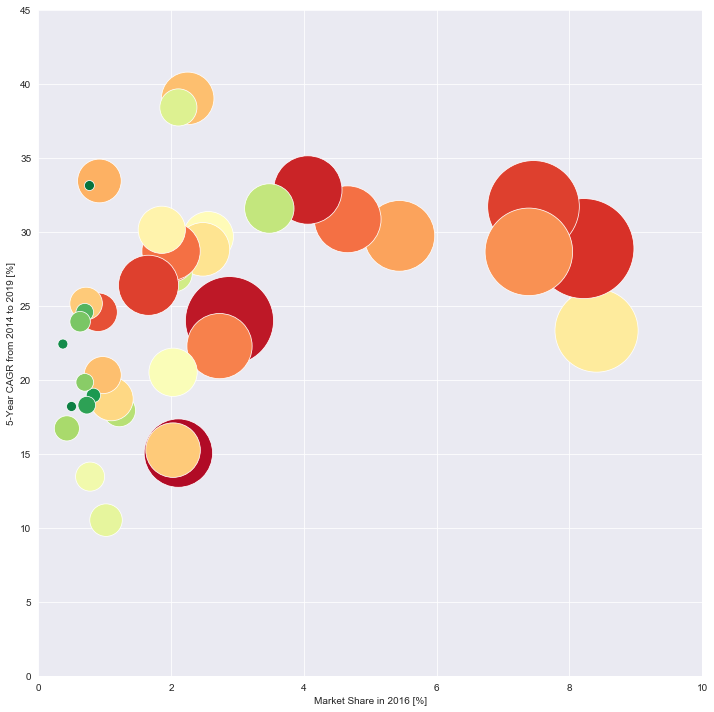

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.relplot(x='Share 2016',
            y='5Y CAGR 2014-2019',
            hue='Dogs per Store',
            palette=sns.color_palette("RdYlGn", 38),
            size='Stores',
            sizes=(100,10000),
            data=bcg_matrix,
            legend=False,
            height=10);
sns.set_style('darkgrid')
ax.set(xlim=(0, 10))
ax.set(ylim=(0, 45))
plt.xlabel('Market Share in 2016 [%]')
plt.ylabel('5-Year CAGR from 2014 to 2019 [%]')

In [267]:
#close connection
close_c_conn()

In [30]:
len(bcg_matrix['Dogs per Store'].unique())

38

In [34]:
import plotly
plotly.tools.set_credentials_file(username=plotly_id, api_key=plotly_key)

In [142]:
import plotly.plotly as py
import plotly.graph_objs as go

hover_text = []
color_range = []
for index, row in bcg_matrix.iterrows():
    hover_text.append(('Borough: {borough}<br>'+
                      'Neighborhood: {neighborhood}<br>'+
                      'Share: {share}%<br>'+
                      'Growth: {growth}%<br>'+
                      'Stores: {stores}<br>'+
                      'Dogs per Store: {pps}').format(borough=row['Borough'],
                                            neighborhood=row['Neighborhood'],
                                            share=row['Share 2016'],
                                            growth=row['5Y CAGR 2014-2019'],
                                            stores=row['Stores'],
                                            pps=row['Dogs per Store']))
    color_range.append(min(row['Dogs per Store'],120))

trace0 = go.Scatter(
    x=bcg_matrix['Share 2016'],
    y=bcg_matrix['5Y CAGR 2014-2019'],
    text=hover_text,
    mode='markers',
    marker=dict(
        size=bcg_matrix['Stores'],
        color=color_range,
        showscale=True,
        reversescale=True,
        colorbar=dict(
                title='Dogs Per Store'
            ),
        colorscale='RdBu'
    )
)

data = [trace0]
layout = go.Layout(
    title='Growth-Share Matrix of Licensed Dogs in New York',
    xaxis=dict(
        title='Neighborhood Share of Licensed Dogs, 2016 [%]',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='5-Year CAGR of Licensed Dogs, 2014-2019 [%]',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bcg-matrix')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

